<a href="https://colab.research.google.com/github/tayyab298/ML-with-JAX/blob/main/MNIST_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training MNIST Dataset using Multilayer Perceptron in JAX 

JAX is a framework for purely functional programming. As a result, we can't use the PyTorch nn.Module semantics to wrap things in class instances or modules.To train a Multilayer Perceptron, we will require the following functions:

A function that returns a list of layer-specific parameters after initialising the neural network weights.

A forward pass through the network is performed by this function (e.g. by loop over the layers).

The cross-entropy loss of the predictions is computed using this function.

A function that assesses the network's correctness (simply for logging).

A function that uses gradient descent to update the parameters.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



#importing some additional JAX and Dataloaders
import numpy as lnp
import jax.numpy as np
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax import grad, jit, vmap, value_and_grad
from jax import random

import torch
from torchvision import datasets, transforms
 
import time




/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [3]:
#setting dataloaders for training and test set

batch_size=100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)





  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([100, 1, 28, 28])

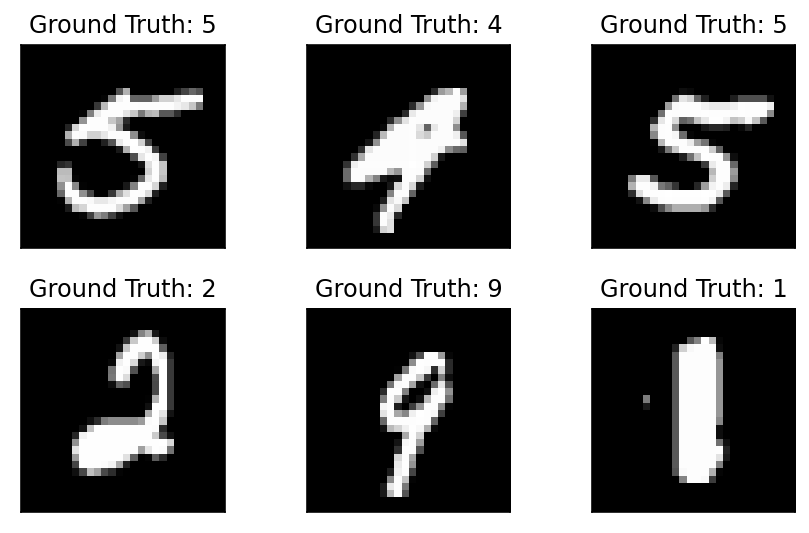

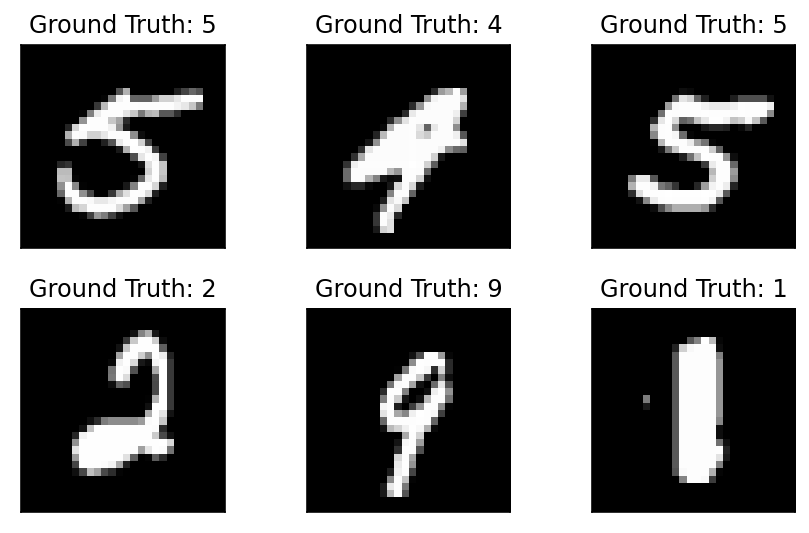

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
key = random.PRNGKey(1)

Next we will need a function that initializes the weights in our MLP. We will pass a list of hidden layer sizes and the previously generated PRNG key. We need to split the key iteratively to generate the individual weights of our network.
i will be doing this for a MLP that takes the flat MNIST image as an input (28 x 28 = 784) and has two hidden layers with 512 units (e.g. 784-512-512-10).

In [7]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [8]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

In [9]:
def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

We now define the forward pass of the network by looping over the layers iteratively and returning the softmax output/predictions log. The single case is then vmapped to create a batch version.

In [10]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array
    
    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)
    
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

We're going to need function to calcualte gradient: To get there, we must first decide which function we want to improve. The multi-class cross-entropy loss between the one-hot encoded class labels ($y_i \in \ {R}^{10}$) and the network's softmax output ( $p^\theta (x_i) \in \ {R}^{10}$) will be:
$$ - \sum_{c=1}^{10} y_{ic} \log p^\theta_{c}(x_i) $$

Finally, for logging purposes we compute the accuracy as well.


In [11]:
def one_hot(x, k , dtype=np.float32):
  """Create a one_hot encoding of x of size k """
  return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
  """ Compute the multi-class cross_entropy loss """
  preds= batch_forward(params, in_arrays)
  return -np.sum(preds * targets)

def accuracy(params, data_loader):
  """ Computing the accuracy """
  acc_total=0;
  for batch_idx, (data, target) in enumerate(data_loader):
      images=np.array(data).reshape(data.size(0),28*28)
      targets = one_hot(np.array(target), num_classes)

      target_class=np.argmax(targets,axis=1)
      predicted_class = np.argmax(batch_forward(params, images), axis=1)
      acc_total += np.sum(predicted_class == target_class)
  return acc_total/len(data_loader.dataset)


We can now combine everything into a single update function that computes the gradient of the loss for a batch of parameters. We select Adam as our optimizer for the initialised parameters using the predefined optimizers, and we're done!

In [12]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

Setup everything - it is time to run the learning loop for the 2-layer MLP!

In [13]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []
    
    # Get the initial set of parameters 
    params = get_params(opt_state)
    
    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    
    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    
    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")


Epoch 1 | T: 18.16 | Train A: 0.974 | Test A: 0.968
Epoch 2 | T: 17.54 | Train A: 0.984 | Test A: 0.973
Epoch 3 | T: 17.45 | Train A: 0.988 | Test A: 0.975
Epoch 4 | T: 17.43 | Train A: 0.993 | Test A: 0.981
Epoch 5 | T: 17.96 | Train A: 0.993 | Test A: 0.979
Epoch 6 | T: 17.33 | Train A: 0.996 | Test A: 0.981
Epoch 7 | T: 17.02 | Train A: 0.996 | Test A: 0.981
Epoch 8 | T: 17.29 | Train A: 0.997 | Test A: 0.981
Epoch 9 | T: 17.22 | Train A: 0.997 | Test A: 0.982
Epoch 10 | T: 16.96 | Train A: 0.998 | Test A: 0.982


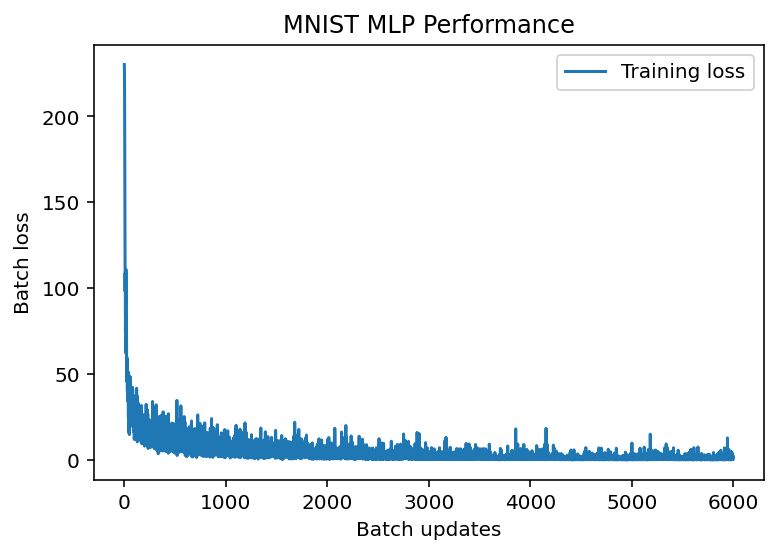

In [32]:
plt.plot(train_loss,label='Training loss')

plt.title('MNIST MLP Performance') 
plt.ylabel('Batch loss')
plt.xlabel('Batch updates')
plt.legend()
plt.show()

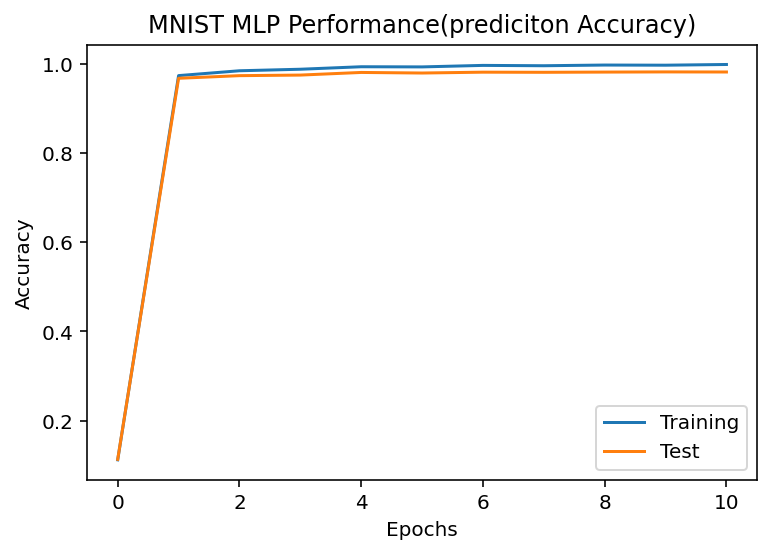

In [35]:
plt.plot(train_log,label='Training')
plt.plot(test_log,label='Test')

plt.title('MNIST MLP Performance(prediciton Accuracy)') 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()